In [1]:
import keras
import numpy as np
import pandas as pd
import importlib.util
import os

from scipy import stats, special, spatial
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# https://github.com/jnothman/UpSetPlot
import upsetplot

import warnings
warnings.filterwarnings('ignore')

#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"


Using TensorFlow backend.


In [2]:
## datasets
folder = '../data/'

# Data
fn1 = 'Linear_regressions.csv'
fn2 = 'combinations.csv'

fname_data1 = folder+'scerevisiae.rsd1.lmbda_22.npz'
fname_module1 = folder+'Model_C3F1codons.py'
fname_p1 = folder+'scerevisiae_good_rsd1_merged_Model_C3F2codons_1236_2f2880478a47edc0fbace7bfd74beecc_best.p'
fname_weights1 = folder+'scerevisiae_good_rsd1_merged_Model_C3F2codons_1236_2f2880478a47edc0fbace7bfd74beecc_best'

fname_module2 = folder+'Model_C3F1stab.py'
fname_p2 = folder+'scerevisiae_good_rsd1_merged_Model_C3F2codons_1236_d4aab8c0b36307f0793558d8fd70dc74_best.p'
fname_weights2 = folder+'scerevisiae_good_rsd1_merged_Model_C3F2codons_1236_d4aab8c0b36307f0793558d8fd70dc74_best'

fn3 = ['substitution_rates.coding.txt',
        'substitution_rates.prom_full.txt',
        'substitution_rates.term_full.txt']


# variables 
names = ['Prom','5UTR','3UTR','Term']


In [3]:
# functions
def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

# expand names
def expand_names(row,names):
    namesh = ['p','5','3','t']
    tmp = []
    for ch in row:
        for i in range(len(namesh)):
            if ch == namesh[i]:
                tmp.append(names[i])
    return tuple(tmp)

def fix_region_order(row):
    return tuple(set(row))

# load modules - POC model
def load_module(model_path):
    '''loads module containing models given path'''
    spec = importlib.util.spec_from_file_location('module',model_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def boxtpm(x, lmbda):
    return special.inv_boxcox(x, lmbda)

def coeff_determination(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true-y_pred))
    SS_tot = np.sum(np.square(y_true-np.mean(y_true)))
    return (1-SS_res/(SS_tot+1e-8))


def load_data(fname):

    npzfile = np.load(fname)
    Xh_train = npzfile['arr_0']
    Xh_test = npzfile['arr_1']
    Xv_train = npzfile['arr_2'][:,8:]
    Xv_test = npzfile['arr_3'][:,8:]
    Y_train = npzfile['arr_4']
    Y_test = npzfile['arr_5']
    names_train = npzfile['arr_6']
    names_test = npzfile['arr_7']

    X_train = list()
    X_train.append(Xh_train)
    #X_train.append(Xv_train)
    X_test = list()
    X_test.append(Xh_test)
    #X_test.append(Xv_test)

    Y_train = Y_train.astype(np.float32).reshape((-1,))
    Y_test = Y_test.astype(np.float32).reshape((-1,))

    return (np.concatenate((Y_train, Y_test)), 
            np.concatenate((names_train,names_test)), 
            np.concatenate((Xv_train,Xv_test)))


# Upset plot region combinations shallow vs deep

In [4]:
df_lin = pd.read_csv(folder+fn1)
df_lin.head()

rsd target    K               features  train_r2   test_r2  train_mse  \
0  rsd1     Yu  K5s  codon_stability_kmers  0.748065  0.728816   0.036861   
1  rsd1     Yu   K5        codon_stability  0.731060  0.719082   0.039349   
2  rsd1     Yu   K4        codon_stability  0.731060  0.719082   0.039349   
3  rsd1     Yu  K5s        codon_stability  0.731060  0.719082   0.039349   
4  rsd1     Yu   K6        codon_stability  0.731060  0.719082   0.039349   

   test_mse  fit_time  score_time  
0  0.039558  0.089291    0.005131  
1  0.041001  0.021826    0.001834  
2  0.041001  0.030200    0.001834  
3  0.041001  0.025381    0.001962  
4  0.041001  0.021319    0.001715

In [5]:
df_lin[(df_lin.rsd=='rsd1')&
       (df_lin.target=='Yc')&
        (df_lin.features=='kmers')]

rsd target    K features  train_r2    test_r2  train_mse  test_mse  \
121  rsd1     Yc  K5s    kmers  0.085726   0.055347   0.117305  0.121040   
123  rsd1     Yc   K4    kmers  0.152916   0.030690   0.108683  0.124076   
140  rsd1     Yc   K5    kmers  0.342981  -0.234417   0.084297  0.157852   
164  rsd1     Yc   K6    kmers  1.000000 -17.295868   0.000000  2.333165   

       fit_time  score_time  
121    0.019275    0.001692  
123    0.408831    0.004730  
140    6.558271    0.018264  
164  235.376283    0.068390

<Figure size 660x480 with 0 Axes>

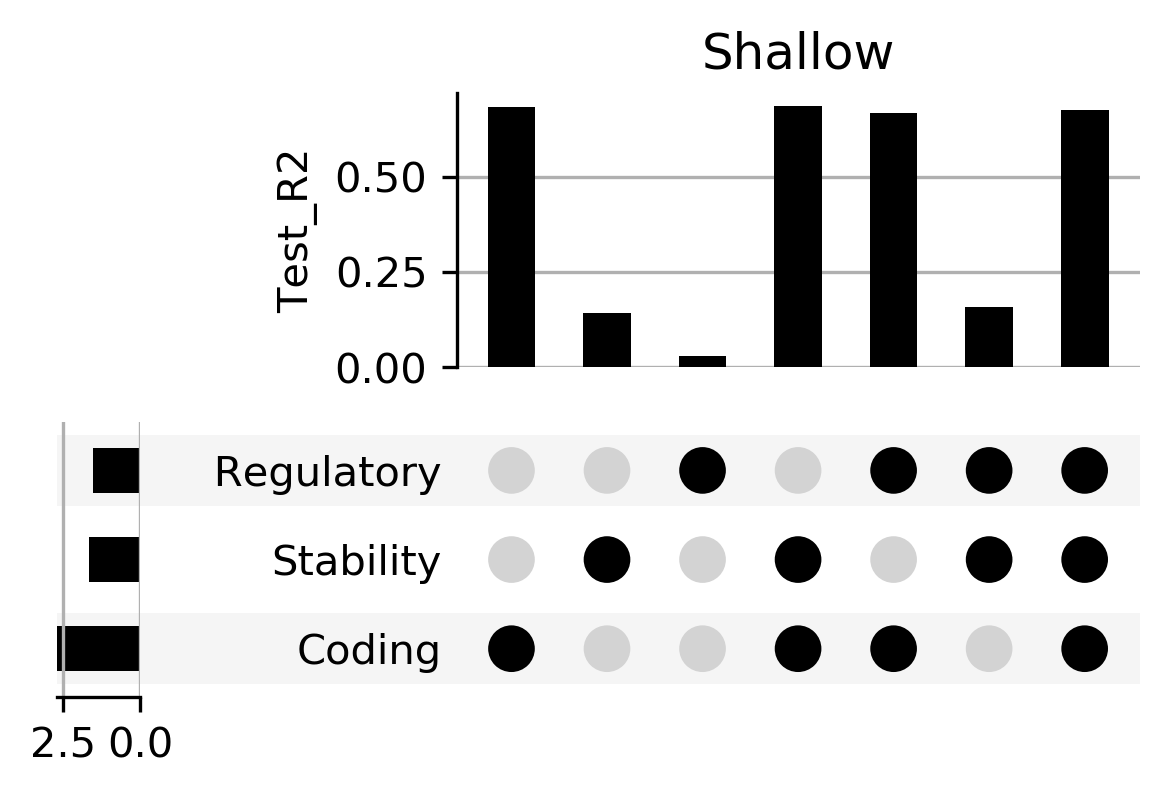

In [12]:
# plot

mpl.rcParams['figure.dpi'] = 300

df_k4 = df_lin[(df_lin.rsd=='rsd1')&
       (df_lin.target=='Yc')&
       (df_lin.K=='K4')]

# split and rename regions
rename = {'kmers':'       Regulatory','codon':'Coding','stability':'Stability'}

df_k4['vars'] = df_k4.features.apply(lambda x: tuple([rename[xx] for xx in x.split('_')]))
df_k4.head(10)

# test upset
data_upset = upsetplot.from_memberships(df_k4.vars.values,data = df_k4[['test_r2']].values)
data_upset = pd.DataFrame(data_upset)
data_upset.columns = ['r2']
data_upset.head()

# SUM OVER
# #upsetplot.plot(data_upset, sum_over='sum_over')
plt.figure(figsize=(2.2,1.6))
upset = upsetplot.UpSet(data_upset, sum_over='r2', intersection_plot_elements=3,
                        subset_size='legacy',
                        facecolor='black', with_lines=False, element_size=32,
                        totals_plot_elements=1, show_counts=None,
                        sort_sets_by='deprecated')
#upset.add_catplot(value='num_rules', kind='strip', color='blue')
upset.plot()
ax = plt.gca()
ax.set_ylabel('Test_R2')
#ax.set_yscale('log')
ax.set_title('Shallow')

plt.savefig('f2a_1.svg')


In [9]:
# estimate some regions

df_deep = df_k4.drop(columns = ['rsd', 'target', 'K', 'features', 
                                'train_r2', 'train_mse',
                               'test_mse', 'fit_time', 'score_time'])
df_deep['test_r2'] = [0.755,0.69,0.822,0.816,0.558,0.378,0.492]

# test upset
data_upset = upsetplot.from_memberships(df_deep.vars.values,data = df_deep[['test_r2']].values)
data_upset = pd.DataFrame(data_upset)
data_upset.columns = ['r2']
data_upset.head()

# # SUM OVER
# # #upsetplot.plot(data_upset, sum_over='sum_over')
# upset = upsetplot.UpSet(data_upset, sum_over='r2', intersection_plot_elements=3)
# #upset.add_catplot(value='num_rules', kind='strip', color='blue')
# upset.plot()
# ax = plt.gca()
# ax.set_ylabel('Test_R2')
# #ax.set_yscale('log')
# ax.set_title('Deep')
    

r2
       Regulatory Coding Stability       
False             True   True       0.755
                         False      0.690
True              True   True       0.822
                         False      0.816
                  False  True       0.558

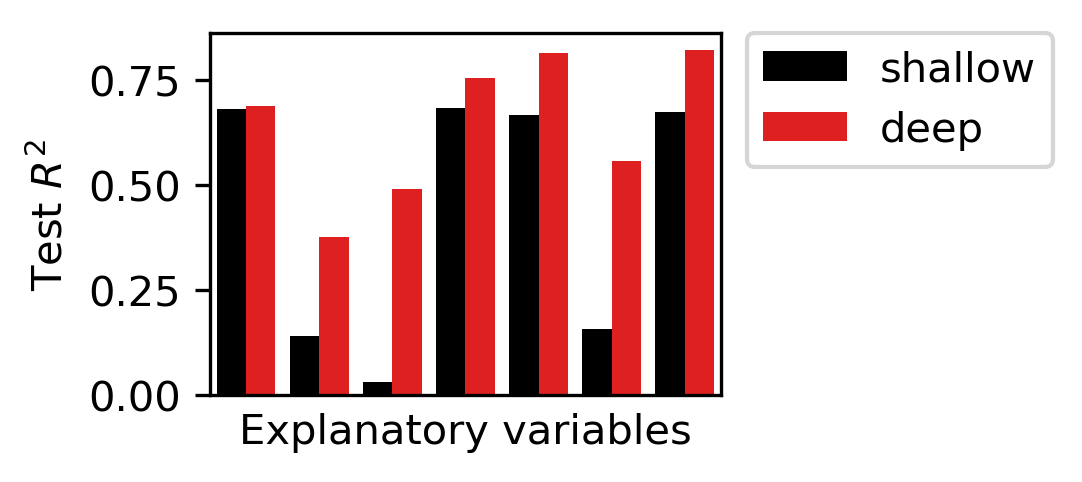

In [10]:
df_k4['model'] = 'shallow'
df_k4['index'] = [3,0,6,4,5,1,2]
df_deep['model'] = 'deep'
df_deep['index'] = [3,0,6,4,5,1,2]

df_plot = (df_k4.drop(columns = ['rsd', 'target', 'K', 'features', 
                                'train_r2', 'train_mse',
                               'test_mse', 'fit_time', 'score_time'])
           .append(df_deep)
          )
df_plot.head()

plt.figure(figsize=(2.2,1.6))
sns.barplot(data=df_plot,x='index',y='test_r2',hue='model',
           palette=["k", "red"])
plt.ylabel('Test $R^2$')
plt.xlabel('')
plt.xticks([])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('Explanatory variables')

plt.savefig('f2a_2.svg')


# Upset plot regions combinations

In [31]:
## import combinations R2

tmp = (pd.read_csv(folder+fn2)
    .transpose()
    .reset_index()
    .drop(index=0)
     )
tmp.columns = ['name','value']
tmp['name'] = tmp.name.apply(lambda x: x.split('.')[0])

tmp = tmp.pivot(index=None,columns='name',values='value')
df_r2 = pd.DataFrame(tmp.filename.dropna().apply(lambda x: x.split('_')[4]).values)
df_r2['r2'] = tmp.test_val_det_k.dropna().values
df_r2.columns = ['region','r2']

df_r2['region'] = df_r2.region.apply(lambda x: fix_region_order(expand_names(x,names)))
df_r2.loc[14,'region'] = ('5UTR','3UTR','Term','Prom')
df_r2.loc[14,'r2'] = 0.492

df_r2


region         r2
0                    (3UTR,)   0.199598
1                    (5UTR,)   0.277308
2                    (Prom,)   0.271125
3                    (Term,)  0.0125674
4               (3UTR, Term)   0.230314
5               (3UTR, 5UTR)   0.392723
6               (Term, 5UTR)   0.267922
7               (3UTR, Prom)   0.337628
8               (Prom, 5UTR)   0.413794
9               (Term, Prom)   0.251736
10        (3UTR, Term, 5UTR)   0.383631
11        (3UTR, Term, Prom)   0.375476
12        (3UTR, Prom, 5UTR)   0.450961
13        (Term, Prom, 5UTR)   0.398516
14  (5UTR, 3UTR, Term, Prom)      0.492

<Figure size 1200x1800 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

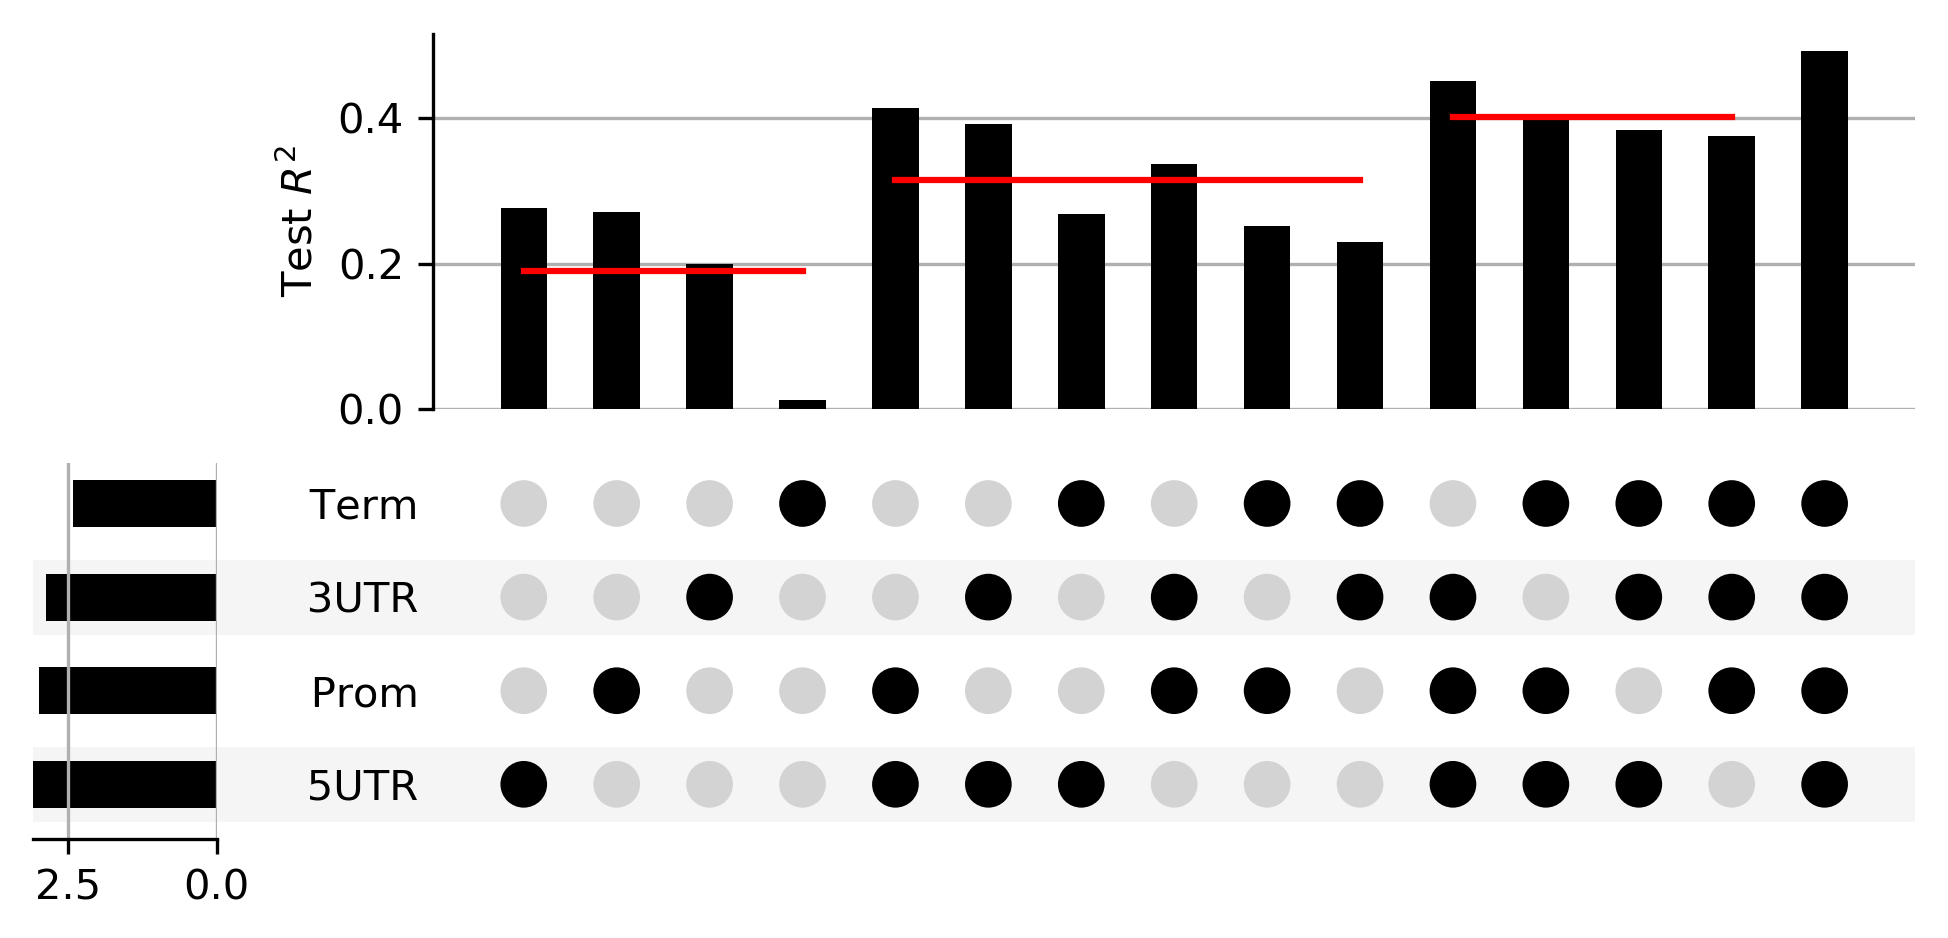

In [32]:
# upset

plt.figure(figsize=(4,6))

# annotation averages
df_r2['region_num'] = df_r2.region.apply(lambda x: len(x))
df_r2.head()

df_r2.groupby('region_num').describe()

df_r2b =(df_r2
 .set_index('region_num')
 .stack()
 .reset_index()
)
df_r2b.columns = ['region_num','measurement','value']
df_r2b.head()

ann = pd.DataFrame(df_r2b[df_r2b.measurement=='r2']
                   .groupby('region_num')['value']
                   .apply(lambda x: np.mean(x)))
ann['length'] = (df_r2b[df_r2b.measurement=='r2']
                 .groupby('region_num')['value']
                 .apply(lambda x: len(x))
                 .values)
ann.head()

# plot

df_r2['region'] = df_r2.region.apply(lambda x: ['   '+xx for xx in x]) 

df_r2.reset_index(inplace=True)

plt.figure(figsize = (10, 10))
data_upset = upsetplot.from_memberships(df_r2.region.values,data = df_r2)
data_upset.head()

upset = upsetplot.UpSet(data_upset,subset_size='sum', sum_over='r2', 
                        intersection_plot_elements=4,with_lines=False)
upset.plot()

ax = plt.gca()
ax.set_ylabel('Test $R^2$')
     
ax.plot([0,3],[ann.loc[1,'value'],ann.loc[1,'value']],'r',zorder=10)
ax.plot([4,9],[ann.loc[2,'value'],ann.loc[2,'value']],'r',zorder=10)
ax.plot([10,13],[ann.loc[3,'value'],ann.loc[3,'value']],'r',zorder=10)
#ax.plot([14],[ann.loc[4,'value']],'r',s=3,zorder=10)

# ax.annotate('1 region',xy=(0.5,0.5),color='r',size=10)
# ax.annotate('2 regions',xy=(5.5,0.5),color='r',size=10)
# ax.annotate('3 regions',xy=(10.5,0.5),color='r',size=10)
# ax.annotate('4 regions',xy=(13,0.5),color='r',size=10)

plt.savefig('f2b_1.svg')


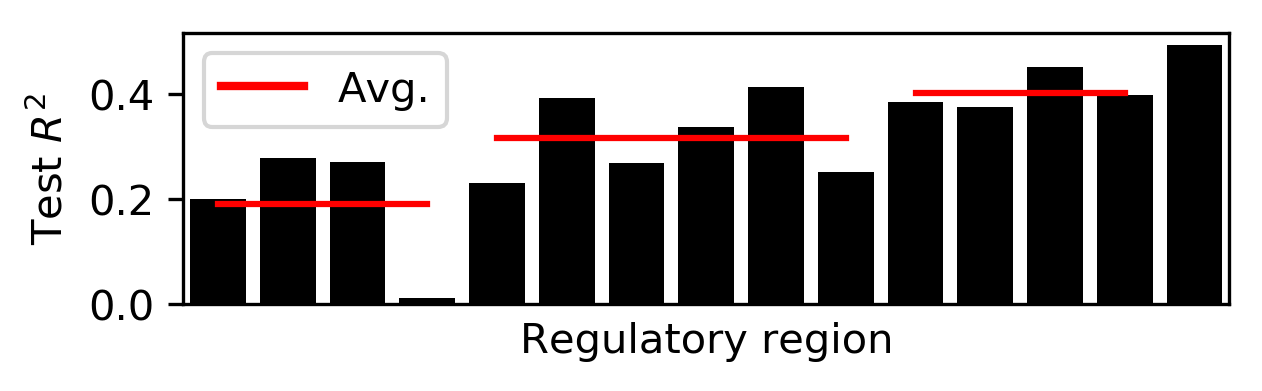

In [35]:
# plot only upper part

# indexes used in upset plot
tmp = [2,3,1,0,9,8,7,6,4,5,13,11,12,10,14]

plt.figure(figsize=(4.5,1.2))
sns.barplot(data=df_r2.iloc[tmp],x='index',y='r2',
           palette=["k"])
plt.ylabel('Test $R^2$')
plt.xlabel('')
plt.xticks([])
plt.xlim(-0.5,14.5)

plt.plot([0,3],[ann.loc[1,'value'],ann.loc[1,'value']],'r',zorder=10)
plt.plot([4,9],[ann.loc[2,'value'],ann.loc[2,'value']],'r',zorder=10)
plt.plot([10,13],[ann.loc[3,'value'],ann.loc[3,'value']],'r',zorder=10)
#ax.plot([14],[ann.loc[4,'value']],'r',s=3,zorder=10)

# ax.annotate('1 region',xy=(0.5,0.5),color='r',size=10)
# ax.annotate('2 regions',xy=(5.5,0.5),color='r',size=10)
# ax.annotate('3 regions',xy=(10.5,0.5),color='r',size=10)
# ax.annotate('4 regions',xy=(13,0.5),color='r',size=10)

custom_lines = [Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['Avg.'])
plt.xlabel('Regulatory region')

plt.savefig('f2b_2.svg')


Text(0.5, 0, 'Number of regions')

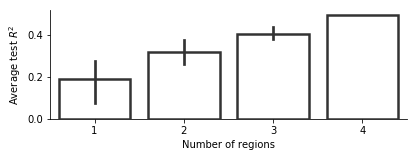

In [14]:
df_r2['region_num'] = df_r2.region.apply(lambda x: len(x))
df_r2.head()

df_r2.groupby('region_num').describe()

df_r2b =(df_r2
 .set_index('region_num')
 .stack()
 .reset_index()
)
df_r2b.columns = ['region_num','measurement','value']
df_r2b.head()
ann = df_r2b[df_r2b.measurement=='r2'].groupby('region_num')['value'].apply(lambda x: np.mean(x))

plt.figure(figsize=(6.4,2))
sns.barplot(x='region_num',y='value',data=df_r2b[df_r2b.measurement=='r2'],
           linewidth=2.5, facecolor=(1, 1, 1, 0),
           errcolor=".2", edgecolor=".2")
sns.despine()
plt.ylabel('Average test $R^2$')
plt.xlabel('Number of regions')



In [15]:
ann = pd.DataFrame(df_r2b[df_r2b.measurement=='r2']
                   .groupby('region_num')['value']
                   .apply(lambda x: np.mean(x)))
ann['length'] = (df_r2b[df_r2b.measurement=='r2']
                 .groupby('region_num')['value']
                 .apply(lambda x: len(x))
                 .values)
ann.head()

value  length
region_num                  
1           0.190150       4
2           0.315686       6
3           0.402146       4
4           0.492000       1

# Vizualization of regions to codons model

In [57]:
## load data and model

module = load_module(fname_module1)

# load p
p = pd.read_csv(fname_p1,sep=';')
p = p.iloc[0]
p.drop(['path','overfit'],inplace=True)
print(p.shape)

# load data
X_train, X_test, Y_train, Y_test = module.load_data(fname_data1) 
Y = np.concatenate((Y_train, Y_test))
X = np.concatenate((X_train[0], X_test[0]))
print(X.shape)
print(Y.shape)

# model
input_shapes = [sl.shape[1:] for sl in X_train]
model = module.POC_model(input_shapes, p)
# set weights model 1
print("Loading model 1 from disk..")
model.load_weights(fname_weights1)


(40,)
(4238, 2150, 4)
(4238, 64)
Loading model 1 from disk..


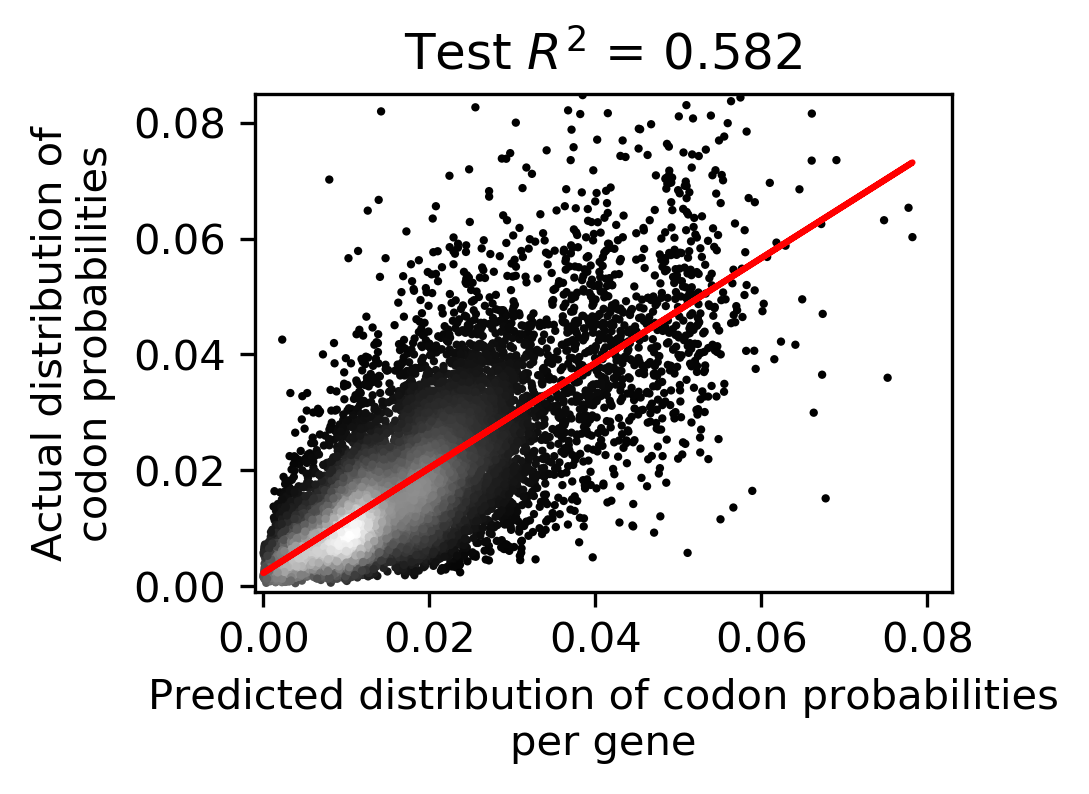

In [64]:
# predict Ypred
Y_pred = model.predict(X)

# flatten vectors and put to df
df_ys = pd.DataFrame([item for el in Y for item in el],columns=['ytrue'])
df_ys['ypred'] = [item for el in Y_pred for item in el]
df_ys.head()
r2 = coeff_determination(df_ys.ytrue.values,df_ys.ypred.values)

# y = df_ys[df_ys > 0].dropna().ytrue.values
# x = df_ys[df_ys > 0].dropna().ypred.values
# slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
# #plt.plot(x, y, 'o', label='original data')
# plt.scatter(x,y,s=1,alpha=0.1,c='k',label='original data')
# plt.plot(x, intercept + slope*x, 'r', label='fitted line')
# #plt.legend()
# plt.xlim(-0.001,0.08)
# plt.ylim(-0.001,0.1)
# plt.xlabel('Predicted distribution of codon probabilities per gene')
# plt.ylabel('Actual distribution of codon probabilities')
# plt.title('$R^2$ = '+str("%.3f" % r2))

# heat scatter aka density

plt.figure(figsize=(3,2.2))

df = df_ys[df_ys > 0].dropna().sample(frac = 0.05,random_state=99)

y = df.ytrue.values
x = df.ypred.values

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(x, y, c=z, s=4, edgecolor='', 
            cmap=plt.cm.gray)

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
plt.plot(x, intercept + slope*x, 'r', label='fitted line')

plt.xlabel('Predicted distribution of codon probabilities\nper gene')
plt.ylabel('Actual distribution of\ncodon probabilities')
plt.title('Test $R^2$ = '+str("%.3f" % r2))
plt.xlim(-0.001,0.083)
plt.ylim(-0.001,0.085)

plt.savefig('f2d.svg')


# Vizualization of regions to stability model

In [48]:
## load data and model

module = load_module(fname_module2)

# load p
p = pd.read_csv(fname_p2,sep=';')
p = p.iloc[0]
p.drop(['path','overfit'],inplace=True)
print(p.shape)

# load data
X_train, X_test, Y_train, Y_test = module.load_data(fname_data1) 
Y = np.concatenate((Y_train, Y_test))
X = np.concatenate((X_train[0], X_test[0]))
print(X.shape)
print(Y.shape)

# model
input_shapes = [sl.shape[1:] for sl in X_train]
model = module.POC_model(input_shapes, p)
# set weights model 1
print("Loading model 1 from disk..")
model.load_weights(fname_weights2)


(40,)
(4238, 2150, 4)
(4238, 8)
Loading model 1 from disk..


In [49]:
# predict Ypred

Y_pred = model.predict(X)


['0.788', '0.782', '0.864', '0.738', '-0.146', '0.682', '0.645', '0.684']


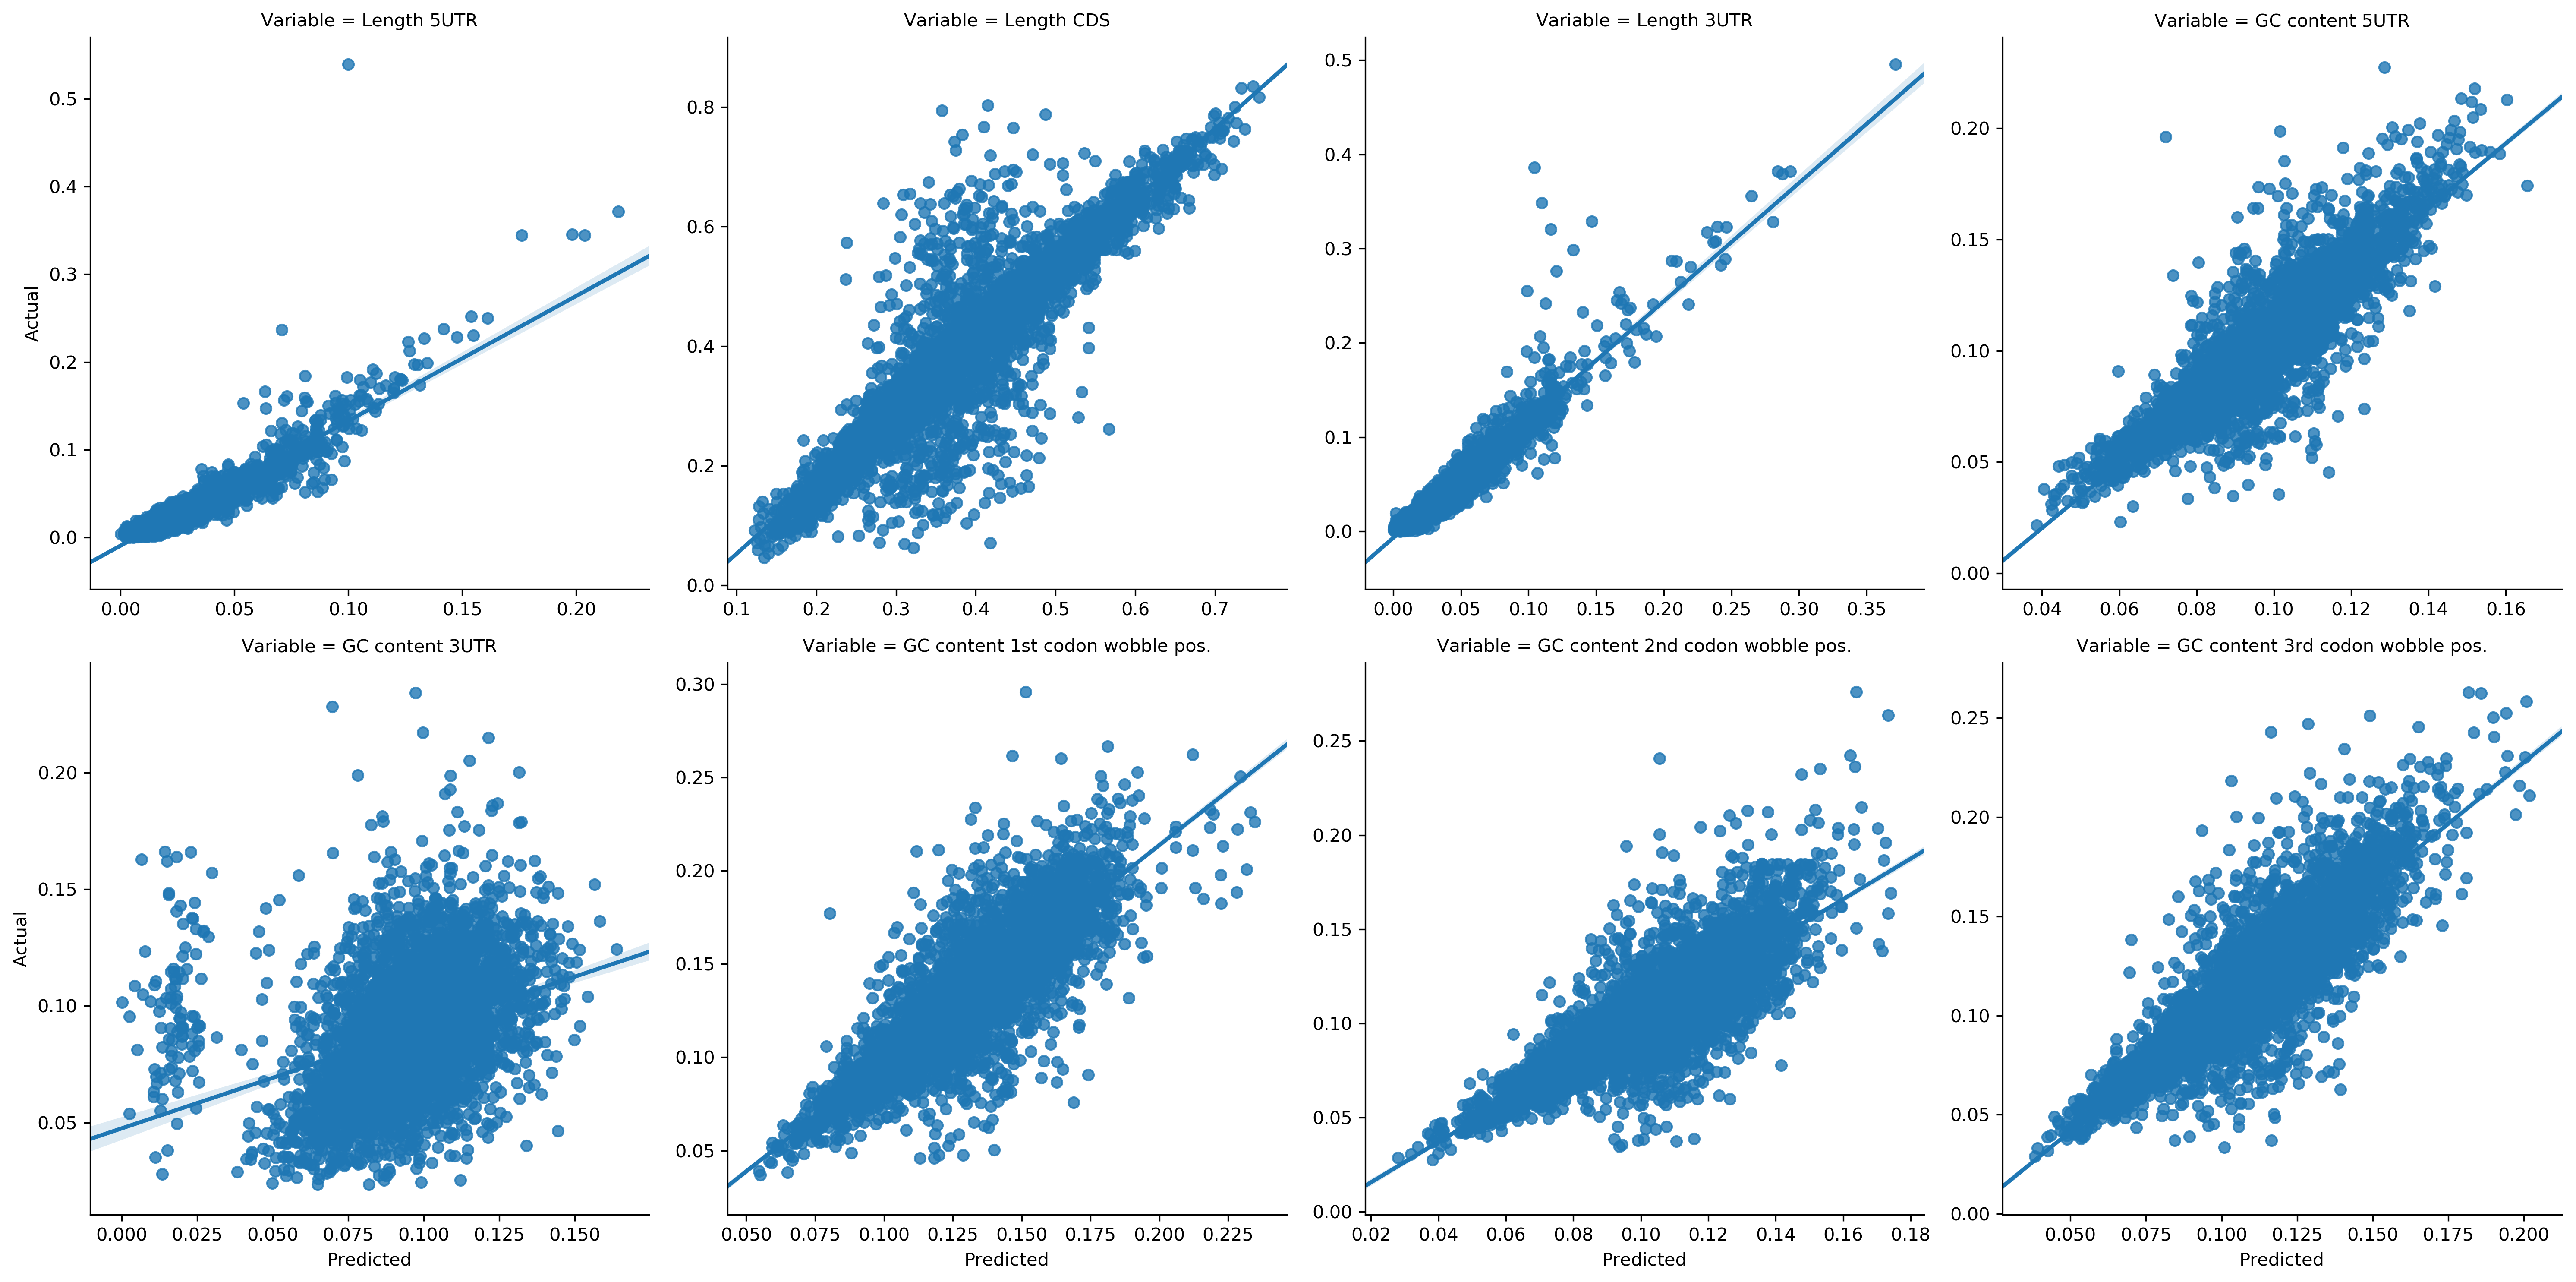

In [50]:
# separate correlation plots for each variable put to supplementary
# for each variable separate plot
# put vars to df

colnames = ['Length 5UTR',
    'Length CDS',
    'Length 3UTR',
    'GC content 5UTR',
    'GC content 3UTR',
    'GC content 1st codon wobble pos.',
    'GC content 2nd codon wobble pos.',
    'GC content 3rd codon wobble pos.']
df_stab = pd.DataFrame(Y,columns=colnames)
#df_stab['dataset'] = 'Actual'
df_stab = pd.DataFrame(df_stab.stack().reset_index(level=1))
df_stab.columns = ['Variable','Actual']

tmp = pd.DataFrame(Y_pred,columns=colnames)
#tmp['dataset'] = 'Predicted'
tmp = pd.DataFrame(tmp.stack().reset_index(level=1))
tmp.columns = ['Variable','Predicted']

df_stab['Predicted'] = tmp.Predicted.values

r2 = []
for val in df_stab.Variable.unique():
    tmp = df_stab[df_stab.Variable == val]
    r2.append(coeff_determination(tmp.Actual.values,tmp.Predicted.values))

df_stab = df_stab.set_index('Variable')
df_stab = df_stab[df_stab > 0].dropna().reset_index()

# df_stab = (df_stab.append(tmp,axis=1)
#            .melt(id_vars=['dataset'],value_vars=colnames)
#            .pivot(columns='dataset', values='value')
#           )
# df_stab.head()

g = sns.lmplot(x="Predicted", y="Actual", col="Variable",
           data=df_stab, sharex=False, sharey=False,
           palette=['black'], col_wrap=4) 
            #height=6, aspect=.4, x_jitter=.1
# k=0
# for ax in g.axes.ravel():
#     plt.annotate(r2[k],(0,0))
#     k+=1

print([("%.3f" % x) for x in r2])


# Visualize evolutionary rates

In [51]:
# load data

colnames = ['gene_id','Mean_alpha','Variance','Lower', 
    'Upper','Median', 'minESS','avgESS','PSRF']

df = []
for fn in fn3:
    df.append((pd
               .read_csv(folder+fn,sep='\t',skiprows=1,
                         header=None,names=colnames))
               .drop(columns=[x for x in colnames if x not in ['gene_id','Median']])
              )
    df[-1]['region'] = fn.split('.')[1].split('_')[0]

df_evol = (pd.concat(df)
           .set_index(['gene_id','region'])
           .unstack()
           .dropna()
           .apply(lambda x: np.log(x+1))
          )
df_evol.columns = df_evol.columns.droplevel()
df_evol.head()
    

region     coding      prom      term
gene_id                              
YAL001C  0.967236  1.851233  1.428866
YAL002W  0.985405  1.935589  1.588656
YAL003W  0.493625  1.190274  0.738305
YAL005C  0.303633  0.680004  0.592006
YAL007C  0.782222  1.449725  1.159555

In [52]:
# load expression data

Y,gene_id,_ = load_data(fname_data1)

bin_edges = [0, .25, .5, .75, 1.]
labels = [0,1,2,3]   
Y_q = np.array(pd.qcut(Y.reshape((-1,)),q=bin_edges,labels=labels, retbins=False))
print(Y_q.shape)

df_exp = pd.DataFrame(Y,columns=['Y'])
df_exp['quartile'] = Y_q
df_exp['gene_id'] = gene_id
df_exp['euclidean'] = distances
df_exp.head()

df_evol = (df_evol
           .reset_index()
           .merge(df_exp,on='gene_id',how='left')
           .dropna()
          )
df_evol.head()


(4238,)


gene_id    coding      prom      term          Y  quartile   euclidean
0  YAL001C  0.967236  1.851233  1.428866   6.606928       1.0   52.732533
1  YAL002W  0.985405  1.935589  1.588656   6.502794       1.0   51.898754
2  YAL003W  0.493625  1.190274  0.738305  18.711905       3.0  149.570633
4  YAL007C  0.782222  1.449725  1.159555   9.470699       3.0   75.642754
5  YAL009W  0.680265  1.238553  1.105200   5.481490       0.0   43.729065

[(0.4533917811059056, 2.3073861307509887e-42), (0.38733219178475764, 7.217003629858893e-35), (0.3561077322603499, 6.482768538300762e-20), (0.40359053469087125, 1.3136731512195561e-35)]


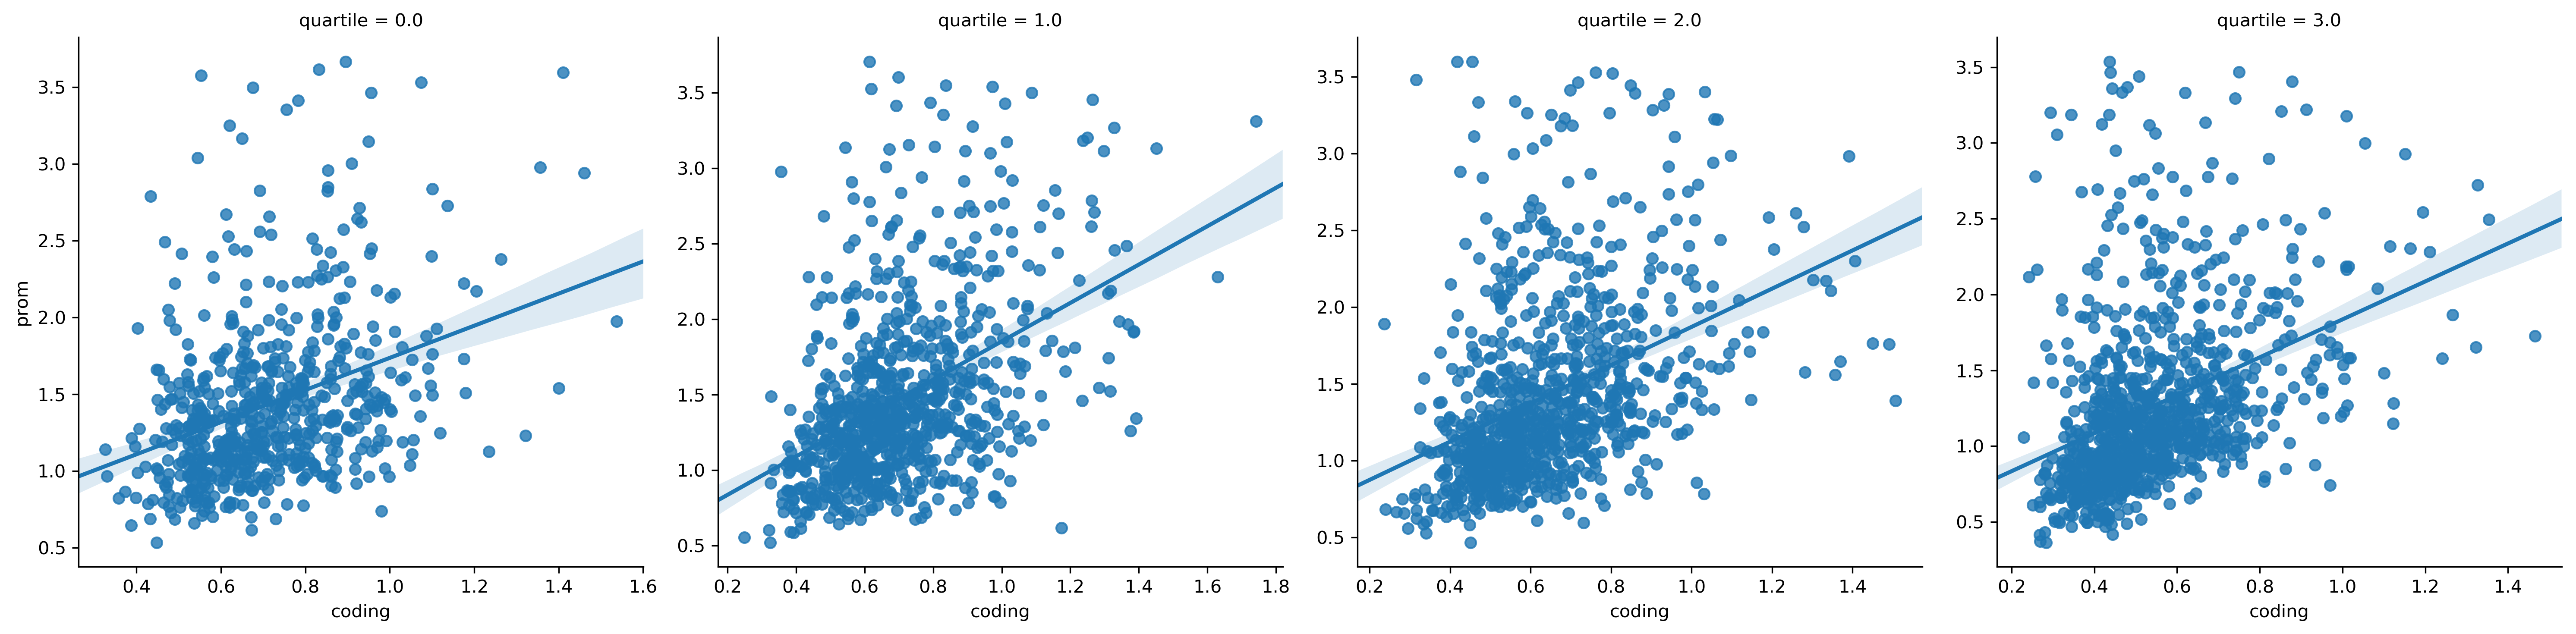

[(0.35844951524454904, 5.380403677094697e-26), (0.5275483106186538, 3.497401577729677e-68), (0.3511933248355588, 2.2339340090389705e-19), (0.45561320348401874, 4.613929060192981e-46)]


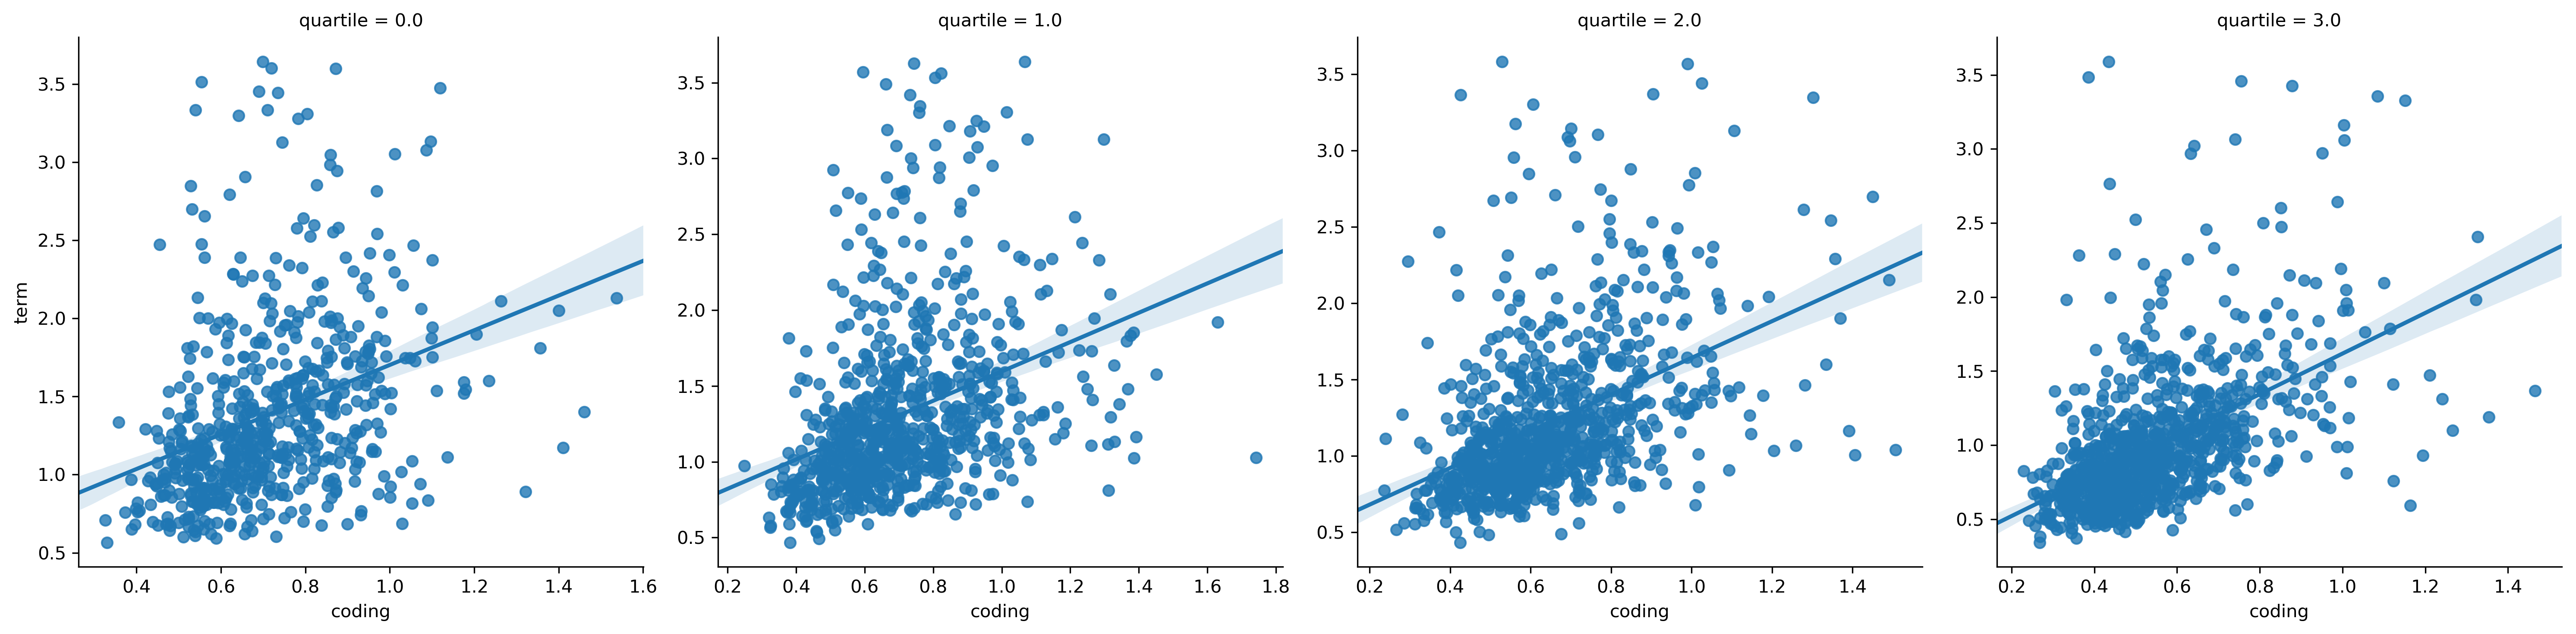

In [53]:
# no significant effect of expression level on correlations

pcc = []
for x in df_evol.quartile.unique():
    tmp = df_evol[df_evol.quartile==x]
    pcc.append(stats.pearsonr(tmp.coding,tmp.prom))
print(pcc)

sns.lmplot(x="coding", y="prom", col="quartile",
           data=df_evol, sharex=False, sharey=False,
           palette=['black'], col_wrap=4) 
plt.show()

pcc = []
for x in df_evol.quartile.unique():
    tmp = df_evol[df_evol.quartile==x]
    pcc.append(stats.pearsonr(tmp.coding,tmp.term))
print(pcc)

sns.lmplot(x="coding", y="term", col="quartile",
           data=df_evol, sharex=False, sharey=False,
           palette=['black'], col_wrap=4) 
plt.show()



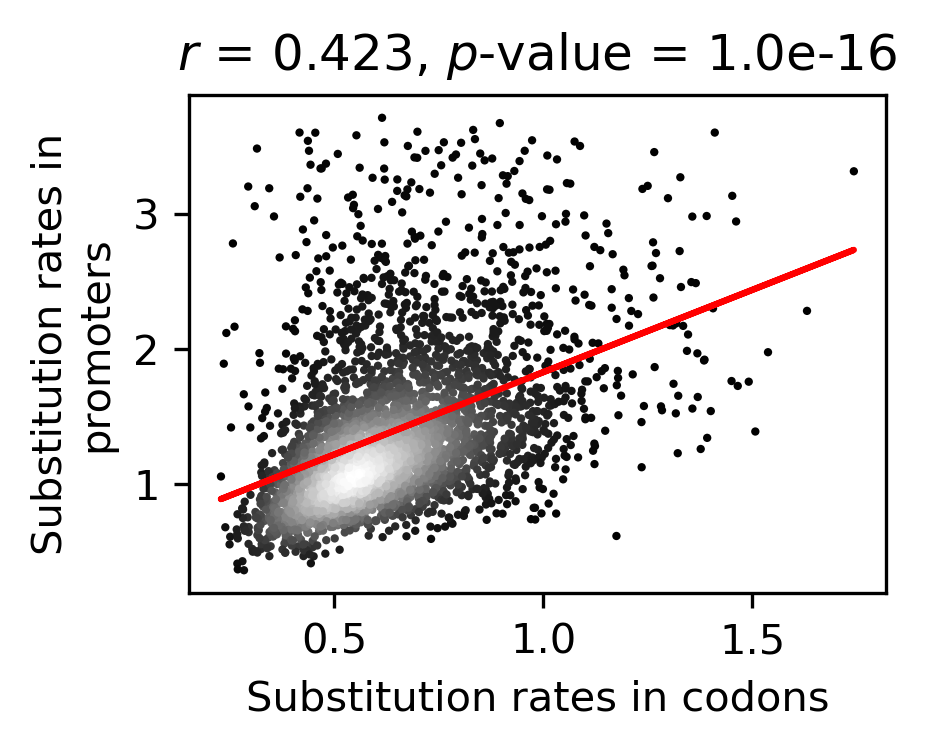

In [54]:
# plots prom term vs coding

plt.figure(figsize=(3,2.2))

# heat scatter aka density
x = df_evol['coding'].values
y = df_evol['prom'].values

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

plt.scatter(x, y, c=z, s=4, edgecolor='', 
            cmap=plt.cm.gray)
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel('Substitution rates in codons')
plt.ylabel('Substitution rates in\npromoters')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value = '+str("%.1e" % fix_pvals(pvalue)))

plt.savefig('f2e.svg')

# #https://www.graphpad.com/guides/prism/7/curve-fitting/reg_fitting_lines_to_semilog.htm?toc=0&printWindow
# plt.scatter(x, y, c=z, s=4, edgecolor='', 
#             cmap=plt.cm.gray)
# plt.plot(x, np.e**(slope*np.log(x) + intercept+np.e/10), 'r', label='fitted line')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Substitution rates in codons')
# plt.ylabel('Substitution rates in/npromoters')
# plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value = '+str("%.1e" % fix_pvals(pvalue)))
# plt.show()



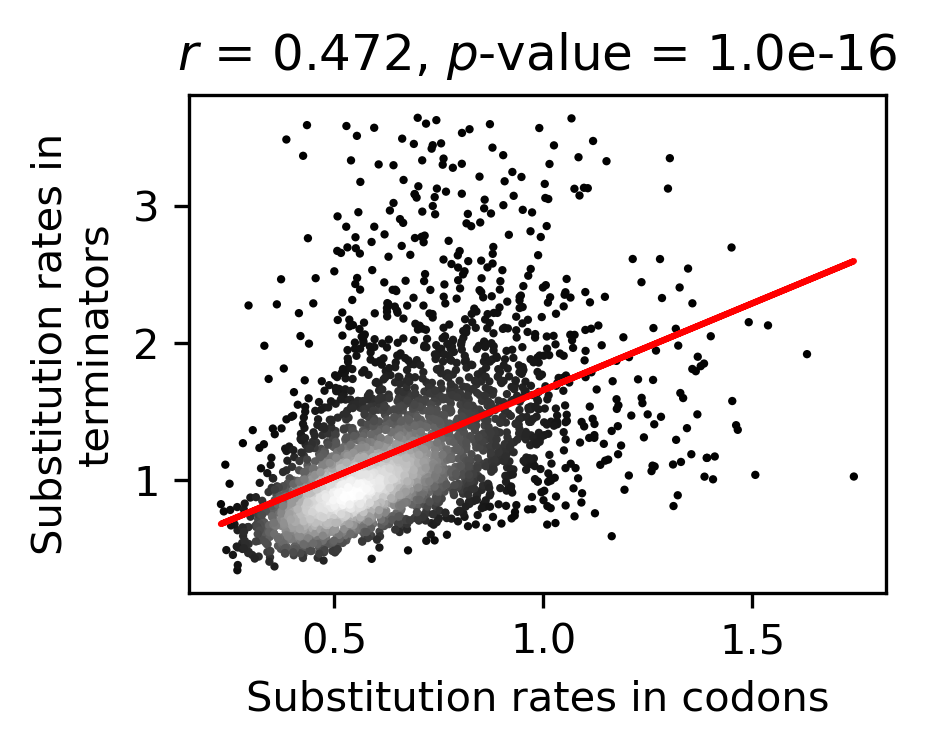

In [55]:
# plots term vs coding

plt.figure(figsize=(3,2.2))

# heat scatter aka density
x = df_evol['coding'].values
y = df_evol['term'].values

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

plt.scatter(x, y, c=z, s=4, edgecolor='', 
            cmap=plt.cm.gray)
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel('Substitution rates in codons')
plt.ylabel('Substitution rates in\nterminators')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value = '+str("%.1e" % fix_pvals(pvalue)))

plt.savefig('f2f.svg')

# #https://www.graphpad.com/guides/prism/7/curve-fitting/reg_fitting_lines_to_semilog.htm?toc=0&printWindow
# plt.scatter(x, y, c=z, s=4, edgecolor='', 
#             cmap=plt.cm.gray)
# plt.plot(x, np.e**(slope*np.log(x) + intercept+np.e/10), 'r', label='fitted line')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Substitution rates in codons')
# plt.ylabel('Substitution rates in\nterminators')
# plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value = '+str("%.1e" % fix_pvals(pvalue)))
# plt.show()


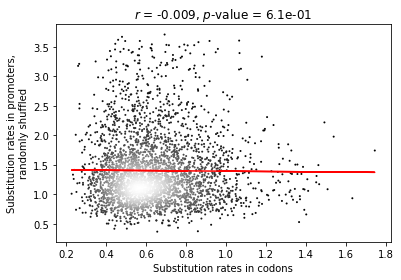

In [41]:
# plots prom term vs coding

#plt.figure(figsize=(3,2.2))

# heat scatter aka density
x = df_evol['coding'].values
y = df_evol['prom'].sample(frac=1,random_state=430).values

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

plt.scatter(x, y, c=z, s=4, edgecolor='', 
            cmap=plt.cm.gray)
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel('Substitution rates in codons')
plt.ylabel('Substitution rates in promoters,\nrandomly shuffled')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value = '+str("%.1e" % fix_pvals(pvalue)))
plt.show()

# #https://www.graphpad.com/guides/prism/7/curve-fitting/reg_fitting_lines_to_semilog.htm?toc=0&printWindow
# plt.scatter(x, y, c=z, s=4, edgecolor='', 
#             cmap=plt.cm.gray)
# plt.plot(x, np.e**(slope*np.log(x) + intercept+np.e/10), 'r', label='fitted line')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Substitution rates in codons')
# plt.ylabel('Substitution rates in/npromoters')
# plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value = '+str("%.1e" % fix_pvals(pvalue)))
# plt.show()


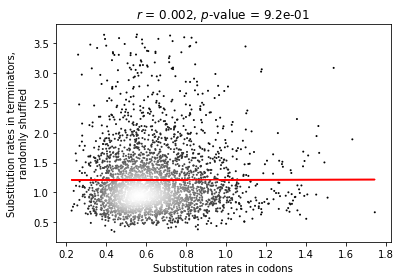

In [42]:
# plots term vs coding

#plt.figure(figsize=(3,2.2))

# heat scatter aka density
x = df_evol['coding'].values
y = df_evol['term'].sample(frac=1,random_state=430).values

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

plt.scatter(x, y, c=z, s=4, edgecolor='', 
            cmap=plt.cm.gray)
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel('Substitution rates in codons')
plt.ylabel('Substitution rates in terminators,\nrandomly shuffled')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value = '+str("%.1e" % fix_pvals(pvalue)))
plt.show()

# #https://www.graphpad.com/guides/prism/7/curve-fitting/reg_fitting_lines_to_semilog.htm?toc=0&printWindow
# plt.scatter(x, y, c=z, s=4, edgecolor='', 
#             cmap=plt.cm.gray)
# plt.plot(x, np.e**(slope*np.log(x) + intercept+np.e/10), 'r', label='fitted line')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Substitution rates in codons')
# plt.ylabel('Substitution rates in\nterminators')
# plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value = '+str("%.1e" % fix_pvals(pvalue)))
# plt.show()

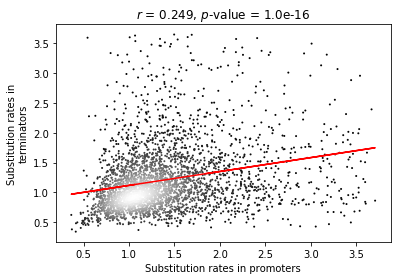

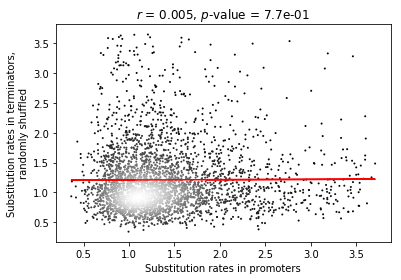

In [45]:
# prom vs term

# heat scatter aka density
x = df_evol['prom'].values
y = df_evol['term'].values

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

plt.scatter(x, y, c=z, s=4, edgecolor='', 
            cmap=plt.cm.gray)
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel('Substitution rates in promoters')
plt.ylabel('Substitution rates in\nterminators')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value = '+str("%.1e" % fix_pvals(pvalue)))
plt.show()

# shuffled control
# heat scatter aka density
x = df_evol['prom'].values
y = df_evol['term'].sample(frac=1,random_state=430).values

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

plt.scatter(x, y, c=z, s=4, edgecolor='', 
            cmap=plt.cm.gray)
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel('Substitution rates in promoters')
plt.ylabel('Substitution rates in terminators,\nrandomly shuffled')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value = '+str("%.1e" % fix_pvals(pvalue)))
plt.show()

